### Import librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings, re, string
from IPython.display import display, Markdown

from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix, precision_score, r2_score, recall_score
from sklearn.pipeline import make_pipeline 
from sklearn.svm import SVC

warnings.filterwarnings('ignore'
                        , category = ConvergenceWarning
                        , module = 'sklearn')

### Función creación de la matríz de confusión.

In [2]:
def matriz(y, pred, Modelo = ''):
    mc = confusion_matrix(y, pred)
    Total = sum(np.transpose(mc))
    mcr = np.transpose(np.round(np.transpose(mc) / Total * 100,2))
    MC = pd.DataFrame(mc, columns=['No', 'Si'])

    MC['index'] = ['No', 'Si']
    MC['No'] *= -1

    Grafico = MC.set_index('index').sort_values(['index']
                                                , ascending=False).plot(kind = 'barh'
                                                                        , stacked = True
                                                                        , width = 0.75
                                                                        , color=[['#c9c9c9','#e60000'],['#00c800','#c9c9c9']]
                                                                        , legend = False
                                                                        , figsize = (3,1.2))
    
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.gca().grid(axis='x',alpha=0)
    plt.gca().grid(axis='y',alpha=0)
    plt.gca().set_xlabel('{:.2f} % - '.format(np.mean(y == pred) * 100) + Modelo
                         , fontsize = 12
                         , alpha = 0.6)
    plt.gca().set_ylabel('')
    
    [spine.set_visible(False) for spine in plt.gca().spines.values()]
    
    plt.show()

In [3]:
def markdown(txt):
    display(Markdown(txt))

### Importación de datos
* Datos de origen en la Url de <i><a href="https://www.kaggle.com/c/fake-news/data">Kaggel</a></i>

In [4]:
df = (pd.read_csv('train.csv')
      .fillna(' ')
      .sample(frac = 1, random_state = 0)
      .set_index('id'))

df.head(3)

,title,author,text,label
id,,,,
20386,Bob Dylan’s Nobel Prize: A Podcast Discussion ...,Jon Pareles,Listen to this week’s podcast | Subscribe: iTu...,0
16794,Nuclear Weapons in South Korea under Discussio...,Author,"Country: South Korea In October 2016, the Pres...",1
5500,Solar Storm Alert,No Author,"October 27, 2016 Solar winds triggered a giant...",1


### Configuramos modelos y preparamos Train y Test

In [5]:
Params = {'Regresión Logística': LogisticRegression(C = 1e5
                                                    , random_state = 0)
           , 'Pasive Aggressive Classifier': PassiveAggressiveClassifier(max_iter = 50
                                                                         , random_state = 0)
           , 'SGD': SGDClassifier(max_iter = 5
                                  , tol = None)
           , 'SVC': SVC(kernel = 'linear'
                        , random_state = 0
                        , gamma = 'scale' )}

XE, XT, ye, yt = train_test_split(df.title + ' ' + df.author + ' ' + df.text
                                  , df.label
                                  , test_size = 0.75
                                  , random_state = 0)

### Comparativa de los distintos modelos:

* Matríz de confusión:

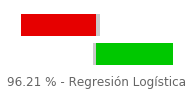

* Precisión modelos sobre base test:

,Modelo,Precisión (accuracy),Cross Val,Score (True),R Cuadrado,Recall
0,Regresión Logística,96.21,0.960577,96.02,0.848203,"[0.96, 0.96]"
1,SGD,96.14,0.958077,96.18,0.845639,"[0.96, 0.96]"
2,SVC,96.13,0.959808,95.94,0.845126,"[0.96, 0.96]"
3,Pasive Aggressive Classifier,96.08,0.958846,96.04,0.843332,"[0.96, 0.96]"


In [6]:
Result = {}
kf = KFold(n_splits = 10)
           
markdown(f'### Comparativa de los distintos modelos:') 
           
for i in Params:
    Score = []
    clf = make_pipeline(TfidfVectorizer(stop_words = 'english', max_df = 0.7)
                         , Params[i])
    
    clf.fit(XE, ye)
    Score.append(round(np.mean(yt == clf.predict(XT)) * 100, 2))
    Score.append(cross_val_score(clf, XE, ye, cv=kf, scoring = 'accuracy').mean())
    Score.append(round(precision_score(yt, clf.predict(XT), labels = [0, 1], pos_label = 1) * 100, 2))
    Score.append(r2_score(yt, clf.predict(XT)))
    Score.append(recall_score(yt, clf.predict(XT), average = None).round(2))
    Result[i] = Score

Result = (pd.DataFrame(Result, index=['Precisión (accuracy)'
                                      , 'Cross Val' 
                                      , 'Score (True)'
                                      , 'R Cuadrado'
                                      , 'Recall'])
          .transpose()
          .sort_values(by = 'Precisión (accuracy)'
                       , ascending = False)
          .reset_index()
          .rename(columns = {'index':'Modelo'})
         )

markdown(f'* Matríz de confusión:')

Best = make_pipeline(TfidfVectorizer(stop_words = 'english', max_df = 0.7)
                         , Params[Result['Modelo'][0]])

Best.fit(XE, ye)

Grafico = matriz(yt, Best.predict(XT), Result['Modelo'][0])        
markdown(f'* Precisión modelos sobre base test:')

Result

* Importamos base test y aplicamos los cambios aplicados en el modelo.

In [7]:
df = (pd.read_csv('test.csv')
      .fillna(' ')
      .set_index('id'))

df.head(3)

,title,author,text
id,,,
20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...
20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...


* Hago predicciones sobre la base test utilizando el modelo que mejor resultado nos ha arrojado.

In [8]:
df['label'] = Best.predict(df.title + ' ' + df.author + ' ' + df.text)

* Exporto predicciones.

In [9]:
df.reset_index()[['id','label']].to_csv('submit.csv', index=False)